In [1]:
# Change runtime to GPU in Colab: Runtime > Change runtime type > GPU
!nvidia-smi

# Install required libraries
!pip -q install -U transformers accelerate datasets evaluate scikit-learn


Sun Aug 24 15:58:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os, random, numpy as np, pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, EarlyStoppingCallback)
import torch

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Model & training config
MODEL_NAME = "hfl/chinese-xlnet-base"  # Pretrained Chinese XLNet
NUM_LABELS = 2                         # Depression = 1, Non-depression = 0
MAX_LEN = 256                          # Max tokens per text
BATCH_SIZE = 16                        # Reduce if GPU OOM
EPOCHS = 6                             # Good start (can tune 5-8)
LR = 2e-5                              # Learning rate


In [4]:
from google.colab import files
uploaded = files.upload()

# If it's a zip file, extract it
import zipfile, os

for fn in uploaded.keys():
    if fn.endswith(".zip"):
        with zipfile.ZipFile(fn, 'r') as zip_ref:
            zip_ref.extractall("/content/WU3D")
        print("Extracted files:", os.listdir("/content/WU3D"))
    else:
        print("Uploaded file:", fn)


Saving WU3D (1).zip to WU3D (1).zip
Extracted files: ['normal.json', 'depressed.json']


In [15]:
import re

def clean_text(text):
    if pd.isna(text):
        return ""
    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    # Remove only control characters (not Chinese/emoji/punctuations)
    text = re.sub(r"[\r\n\t]", " ", text)
    # Normalize multiple spaces
    text = " ".join(text.split())
    return text.strip()

df["text"] = df["text"].astype(str).apply(clean_text)
df = df[df["text"].str.strip() != ""].reset_index(drop=True)

print(df.head(10))
print("Shape after cleaning:", df.shape)


   label                                               text
0      1  有点累想休息了 为什么总有领导作为外行人在不了解的情况下就异想天开的安排人做一些完全不可能做...
1      1  轉發微博 轉發微博 张艺兴joker为了肚子穿的宽松 苏州 人活着最重要的就是开心啦 苏州 ...
2      1  抑郁症的普及它好就好在 以前人抑郁的时候想死 现在人抑郁的时候想我要不要吃点药看看医生 抑郁...
3      1  感觉坚持不下去了我想解脱了 晚上饿猛啃了几根辣条现在肚子胀的难受 拘泥于自己的鸡心螺壳中是什...
4      1  所有人都问我你没事吧你还好吧 我笑着一一回答我很好啊没有问题没事的你看我像有什么事的样子吗 ...
5      1  害з∠ 每天除了吃饭睡觉就是喂奶吸奶 每天都是吐不出来的恶心反胃 每次醒来都会以为又过了一天...
6      1  反胃 每次脆弱的时候阳光总是突然出现 谁爱我我爱谁 真特么烦打麻将的 无的对视10秒20秒兄...
7      1  总是莫名其妙流眼泪 感觉生活无趣 我感觉自己好压抑 不为什么 没有原因 这是不是抑郁症的前兆...
8      1  回来啦 竟然为了追星下回来了 真的好讨厌自己 我的抑郁好像好了你们知道吗在我卸载的这段时间里...
9      1  在有缘网有一种爱明明是深爱却说不出来有一种爱明明想放手却无法离弃 有一种爱明知是煎熬却又躲不...
Shape after cleaning: (32568, 2)


In [6]:
import os
os.listdir("/content")


['.config', 'WU3D (1).zip', 'WU3D', 'sample_data']

In [12]:
import json
import pandas as pd

# Load JSON files from the WU3D folder
with open("/content/WU3D/depressed.json", "r", encoding="utf-8") as f:
    depressed = json.load(f)

with open("/content/WU3D/normal.json", "r", encoding="utf-8") as f:
    normal = json.load(f)

print("Depressed sample keys:", depressed[0].keys())
print("Normal sample keys:", normal[0].keys())


Depressed sample keys: dict_keys(['label', 'nickname', 'gender', 'profile', 'birthday', 'num_of_follower', 'num_of_following', 'all_tweet_count', 'original_tweet_count', 'repost_tweet_count', 'tweets'])
Normal sample keys: dict_keys(['label', 'nickname', 'gender', 'profile', 'birthday', 'num_of_follower', 'num_of_following', 'all_tweet_count', 'original_tweet_count', 'repost_tweet_count', 'tweets'])


In [11]:
def extract_text(user):
    tweets = user.get("tweets", [])
    return " ".join([t.get("tweet_content", "") for t in tweets if "tweet_content" in t])


In [14]:
# Depressed = label 1
depressed_df = pd.DataFrame({
    "label": 1,
    "text": [extract_text(u) for u in depressed]
})

# Normal = label 0
normal_df = pd.DataFrame({
    "label": 0,
    "text": [extract_text(u) for u in normal]
})

# Combine
df = pd.concat([depressed_df, normal_df], ignore_index=True)
df = df[df["text"].str.strip() != ""].reset_index(drop=True)

print("Final dataset shape:", df.shape)
df.head(5)


Final dataset shape: (32568, 2)


,label,text
0,1,有点累想休息了 为什么总有领导作为外行人在不了解的情况下就异想天开的安排人做一些完全不可能做...
1,1,轉發微博 轉發微博 张艺兴joker为了肚子穿的宽松 苏州 人活着最重要的就是开心啦 苏州 ...
2,1,抑郁症的普及它好就好在 以前人抑郁的时候想死 现在人抑郁的时候想我要不要吃点药看看医生 抑郁...
3,1,感觉坚持不下去了我想解脱了 晚上饿猛啃了几根辣条现在肚子胀的难受 拘泥于自己的鸡心螺壳中是...
4,1,所有人都问我你没事吧你还好吧 我笑着一一回答我很好啊没有问题没事的你看我像有什么事的样子吗 ...


In [16]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=RANDOM_SEED)
val_df, test_df  = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=RANDOM_SEED)

print("Train/Val/Test:", train_df.shape, val_df.shape, test_df.shape)


Train/Val/Test: (26054, 2) (3257, 2) (3257, 2)


In [17]:
from datasets import Dataset, DatasetDict

hf_ds = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True))
})
hf_ds


DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 26054
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 3257
    })
})

In [18]:
from transformers import AutoTokenizer

MODEL_NAME = "hfl/chinese-xlnet-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

MAX_LEN = 256

def tokenize_fn(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_LEN)

hf_ds = hf_ds.map(tokenize_fn, batched=True, remove_columns=["text"])
hf_ds.set_format(type="torch")
hf_ds


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/691k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/202 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/26054 [00:00<?, ? examples/s]

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 26054
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3257
    })
})

In [19]:
from transformers import AutoModelForSequenceClassification

NUM_LABELS = 2
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)


pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-xlnet-base and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

EPOCHS = 6
BATCH_SIZE = 16   # use 8 if GPU memory is low
LR = 2e-5

training_args = TrainingArguments(
    output_dir="xlnet-wu3d",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    warmup_ratio=0.06,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=RANDOM_SEED
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="binary"),
        "precision": precision_score(labels, preds, average="binary"),
        "recall": recall_score(labels, preds, average="binary"),
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_ds["train"],
    eval_dataset=hf_ds["validation"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [21]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.198600,0.211964,0.936752,0.897103,0.926729,0.869313
2,0.140900,0.224296,0.933681,0.885593,0.977778,0.809293
3,0.097900,0.272290,0.939515,0.899541,0.950431,0.853824
4,0.056300,0.351819,0.934602,0.892587,0.931579,0.856728
5,0.024600,0.478448,0.933988,0.890474,0.939785,0.846079


TrainOutput(global_step=8145, training_loss=0.1223909245304274, metrics={'train_runtime': 3363.9127, 'train_samples_per_second': 46.471, 'train_steps_per_second': 2.906, 'total_flos': 1.855567700861952e+16, 'train_loss': 0.1223909245304274, 'epoch': 5.0})

In [37]:
# Save best model
trainer.save_model("best_model/")
tokenizer.save_pretrained("best_model/")

# Load it back
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("best_model/")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [24]:
predictions = trainer.predict(hf_ds["test"])
logits = predictions.predictions
labels = predictions.label_ids

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(logits, axis=1)

# Assuming id2label is defined elsewhere or can be inferred
# If id2label is not defined, you might need to define it based on your labels (0 and 1)
# For example: id2label = {0: "Non-depression", 1: "Depression"}
# print(classification_report(labels, y_pred, target_names=[id2label[i] for i in sorted(id2label.keys())]))
print(classification_report(labels, y_pred))


cm = confusion_matrix(labels, y_pred)
print("Confusion Matrix:\n", cm)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2225
           1       0.95      0.85      0.90      1032

    accuracy                           0.94      3257
   macro avg       0.94      0.92      0.93      3257
weighted avg       0.94      0.94      0.94      3257

Confusion Matrix:
 [[2175   50]
 [ 150  882]]


In [26]:
from sklearn.metrics import roc_auc_score, average_precision_score
import torch

if NUM_LABELS == 2:
    y_score = torch.softmax(torch.tensor(logits), dim=1)[:,1].numpy()
    print("ROC AUC:", roc_auc_score(labels, y_score))
    print("Average Precision (PR AUC):", average_precision_score(labels, y_score))

ROC AUC: 0.9707749760473825
Average Precision (PR AUC): 0.9599553664293045


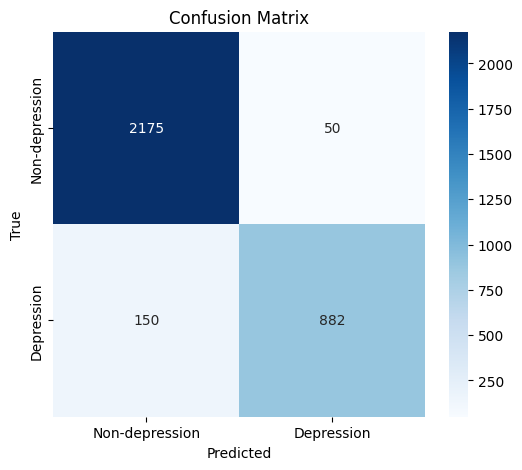

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, y_pred)

# Define id2label dictionary
id2label = {0: "Non-depression", 1: "Depression"}

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=[id2label[i] for i in sorted(id2label.keys())],
            yticklabels=[id2label[i] for i in sorted(id2label.keys())])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

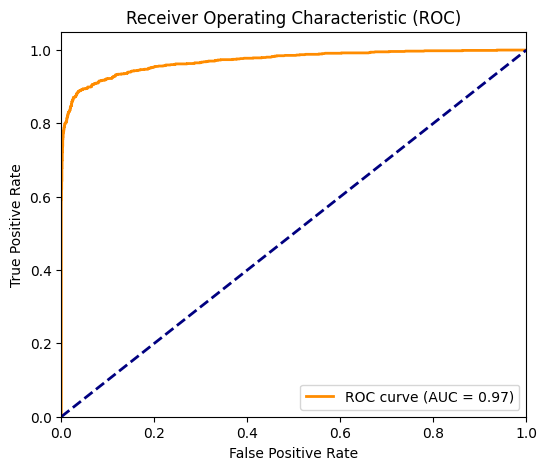

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

if NUM_LABELS == 2:
    fpr, tpr, _ = roc_curve(labels, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.show()

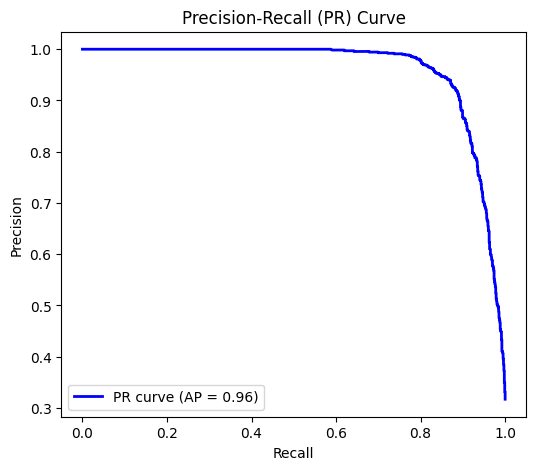

In [32]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

if NUM_LABELS == 2:
    precision, recall, _ = precision_recall_curve(labels, y_score)
    avg_precision = average_precision_score(labels, y_score)

    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, color="blue", lw=2,
             label=f"PR curve (AP = {avg_precision:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall (PR) Curve")
    plt.legend(loc="lower left")
    plt.show()

In [35]:
from datasets import concatenate_datasets

# Combine the datasets
combined_dataset = concatenate_datasets([hf_ds["train"], hf_ds["validation"], hf_ds["test"]])

# Prepare data for k-fold split
X = combined_dataset["input_ids"] # Assuming input_ids are the main features
y = combined_dataset["label"]

print(f"Combined dataset size: {len(combined_dataset)}")
print(f"Shape of X: {len(X)}")
print(f"Shape of y: {len(y)}")

Combined dataset size: 32568
Shape of X: 32568
Shape of y: 32568


In [ ]:
# Zip the folder
!zip -r best_model.zip best_model

# Download the zip file
from google.colab import files
files.download("best_model.zip")


In [38]:
# Zip the folder
!zip -r best_model.zip best_model

# Download the zip file
from google.colab import files
files.download("/content/best_model")


  adding: best_model/ (stored 0%)
  adding: best_model/training_args.bin (deflated 53%)
  adding: best_model/model.safetensors (deflated 7%)
  adding: best_model/config.json (deflated 52%)
  adding: best_model/special_tokens_map.json (deflated 83%)
  adding: best_model/spiece.model (deflated 46%)
  adding: best_model/tokenizer_config.json (deflated 82%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>